In [2]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 724.1 kB/s eta 0:00:00:--:--


In [3]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import segmentation_models as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from PIL import Image
from glob import glob
#from sklearn.utils import shuffle
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input ,MaxPool2D, Concatenate,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
#from tqdm import tqdm

Segmentation Models: using `keras` framework.


In [4]:
BACKBONE = 'resnet34'
pre_inputs = sm.get_preprocessing(BACKBONE)

In [5]:
csv_df = pd.read_csv('../input/pcd-train/train.csv')

In [6]:
csv_df['gleason_score'] = csv_df['gleason_score'].apply(lambda x: '0+0' if x == 'negative' else x)

In [7]:
ID = csv_df['image_id'] + '.png'
csv_df['image_id'] = ID
csv_df.head(10)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917.png,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d.png,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa.png,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9.png,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f.png,karolinska,0,0+0
5,002a4db09dad406c85505a00fb6f6144.png,karolinska,0,0+0
6,003046e27c8ead3e3db155780dc5498e.png,karolinska,1,3+3
7,0032bfa835ce0f43a92ae0bbab6871cb.png,karolinska,1,3+3
8,003a91841da04a5a31f808fb5c21538a.png,karolinska,1,3+3
9,003d4dd6bd61221ebc0bfb9350db333f.png,karolinska,1,3+3


In [8]:
csv_df['isup_grade'].value_counts()

0    2892
1    2666
2    1343
4    1249
3    1242
5    1224
Name: isup_grade, dtype: int64

In [9]:
csv_df['data_provider'].value_counts()

karolinska    5456
radboud       5160
Name: data_provider, dtype: int64

In [10]:
mask_labels = os.listdir('../input/panda2/train_label_masks')

In [11]:
df_mask = pd.Series(mask_labels).to_frame()
df_mask.columns = ['mask_id']
df_mask['image_id'] = df_mask.mask_id.apply(lambda x: x.split('_')[0])
df_train = pd.merge(csv_df, df_mask, on = 'image_id', how = 'outer')

In [12]:
xdf = df_train[df_train['image_id'] != df_train['mask_id']]

In [13]:
img_del = xdf['image_id'].values

In [14]:
a = list(img_del) 

In [15]:
x = df_train[df_train['image_id'] != df_train['mask_id']].index

In [16]:
ndf = df_train.drop(x)

In [17]:
y = ndf.drop(['image_id','data_provider','mask_id','gleason_score'], axis=1)
y = y.to_numpy()
y.shape

(10516, 1)

In [18]:
img_names = glob('/kaggle/input/panda2/train_images/*.png')
img_names.sort()
len(img_names)

10616

In [19]:
type(img_names)

list

In [23]:
# removing unwanted images if it display error list index out of range ran it once again.
for i in range(len(img_names)):
    if i <= len(img_names):
        for j in range(len(a)):
            if (img_names[i][-36:] == a[j]):
                x = img_names[i].index
                #print(i)
                del img_names[i]

In [24]:
#length of list after removing
len(img_names)

10516

In [26]:
#sorting once again
img_names.sort()

In [27]:
#Capture training image info as a list
train_images = []
print(len(img_names))
for i in range(len(img_names)):
        img = cv2.imread(img_names[i],cv2.IMREAD_COLOR)
        img = cv2.resize(img,(128,128))
        img = img/255
        train_images.append(img)

10516


In [28]:
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [29]:
#shape after converting images into arrays
train_images.shape

(10516, 128, 128, 3)

In [30]:
msk_names = glob('/kaggle/input/panda2/train_label_masks/*.png')
msk_names.sort()

In [31]:
#Capture mask/label info as a list
train_masks = [] 
for i in range(len(msk_names)):
        mask = cv2.imread(msk_names[i],cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(128,128))
        mask = mask/255
        mask = np.expand_dims(mask, axis=-1)
        train_masks.append(mask)

In [32]:
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [33]:
train_masks.shape

(10516, 128, 128, 1)

In [34]:
train_images.sort()

In [35]:
train_masks.sort()

8544


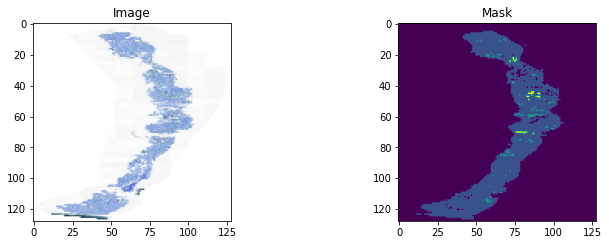

In [36]:
import random
img_number = random.randint(0, len(train_images)-1)
img = train_images[img_number]
mask = train_masks[img_number]
print(img_number)

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [37]:
x_train , x_val, y_train , y_val = train_test_split(train_images,train_masks, test_size = 0.2,random_state = 42)

In [38]:
print(len(x_train) , len(x_val), len(y_train) ,len( y_val))

8412 2104 8412 2104


In [39]:
x_train = pre_inputs(x_train)
x_val = pre_inputs(x_val)

In [40]:
model = sm.Unet(BACKBONE,encoder_weights = y.all())
model.compile(optimizer = 'adam', loss =sm.losses.bce_jaccard_loss, metrics = ['mse', 'accuracy'] )

2022-12-02 15:59:26.374727: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [46]:
#early stoping
es = EarlyStopping(monitor='val_accuracy',min_delta=0.01, patience=3,verbose=1, mode='auto')
# check point
mc = ModelCheckpoint(monitor='val_accuracy', filepath="/kaggle/working/bestmodel.h5", verbose=1, save_best_only=True, mode= 'auto')

cd= [es,mc]

In [ ]:
history = model.fit(x_train,y_train, batch_size =16, epochs= 10, verbose=1, validation_data=(x_val,y_val), callbacks= cd)

Epoch 1/10
526/526 [==============================] - ETA: 0s - loss: 1.0041 - mse: 1.5364e-04 - accuracy: 0.8789

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs,loss, 'y', label = 'Training_loss')
plt.plot(epochs,val_loss, 'r', label = 'validation_loss')
plt.title('training and validation losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [ ]:
def plot_accuracy(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()
  
plot_accuracy(history)